In [1]:
import pandas as pd
import numpy as np

from dataprep.eda import plot
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


from aif360 import datasets
from aif360.datasets import BinaryLabelDataset
from aif360.explainers import MetricTextExplainer
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from aif360.algorithms.preprocessing.reweighing import Reweighing

NumExpr defaulting to 4 threads.


In [2]:
#reading the data stored in s3 bucket
data =pd.read_csv('https://chidu-proj.s3.amazonaws.com/compas-scores-two-years.csv')

In [3]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
#checking for the null values in the data
data.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [5]:
data.shape

(7214, 53)

In [6]:
#checking for the columns which have more than 10% of the missing data
feature_names= list(data)
feature_to_drop =[]
for i in feature_names:
    null_values = data[i].isnull().sum()
    r,c = data.shape
    missing_value_percent = (null_values/r)*100
    if (missing_value_percent >=10):
        feature_to_drop.append(i)
    print(i +" " + ":" + " " + "Null_value_Percentage" + "=" + str(missing_value_percent) + "%","\n")

id : Null_value_Percentage=0.0% 

name : Null_value_Percentage=0.0% 

first : Null_value_Percentage=0.0% 

last : Null_value_Percentage=0.0% 

compas_screening_date : Null_value_Percentage=0.0% 

sex : Null_value_Percentage=0.0% 

dob : Null_value_Percentage=0.0% 

age : Null_value_Percentage=0.0% 

age_cat : Null_value_Percentage=0.0% 

race : Null_value_Percentage=0.0% 

juv_fel_count : Null_value_Percentage=0.0% 

decile_score : Null_value_Percentage=0.0% 

juv_misd_count : Null_value_Percentage=0.0% 

juv_other_count : Null_value_Percentage=0.0% 

priors_count : Null_value_Percentage=0.0% 

days_b_screening_arrest : Null_value_Percentage=4.255614083726089% 

c_jail_in : Null_value_Percentage=4.255614083726089% 

c_jail_out : Null_value_Percentage=4.255614083726089% 

c_case_number : Null_value_Percentage=0.3049625727751594% 

c_offense_date : Null_value_Percentage=16.065982811200445% 

c_arrest_date : Null_value_Percentage=84.23897976157471% 

c_days_from_compas : Null_value_Percen

In [7]:

plot(data)

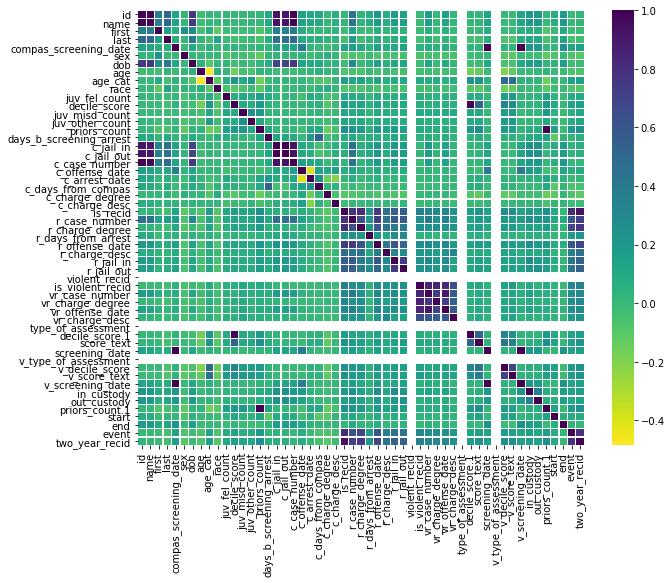

In [8]:
#Plotting the heatmap for the correlated features
plt.figure(figsize=(10,8))
corr=data.apply(lambda x: pd.factorize(x)[0]).corr()
ax=sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, linewidth=0.2, cmap='viridis_r')

In [9]:
#features to drop on the basis of the no of elements missing in the row(columns having more than 10% missing data)
feature_to_drop

['c_offense_date',
 'c_arrest_date',
 'r_case_number',
 'r_charge_degree',
 'r_days_from_arrest',
 'r_offense_date',
 'r_charge_desc',
 'r_jail_in',
 'r_jail_out',
 'violent_recid',
 'vr_case_number',
 'vr_charge_degree',
 'vr_offense_date',
 'vr_charge_desc']

In [10]:
data=data.drop(columns=feature_to_drop)

In [11]:
data.shape

(7214, 39)

In [12]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [13]:
print(list(data))

['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'is_violent_recid', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']


In [14]:
#creating an empty list
drop=[]

In [15]:
#both are same, we cak keep one.
data[['decile_score.1','decile_score']]


,decile_score.1,decile_score
0,1,1
1,3,3
2,4,4
3,8,8
4,1,1
...,...,...
7209,7,7
7210,3,3
7211,1,1
7212,2,2


In [16]:
drop.append('decile_score.1')

In [17]:
#type of assesment is same for all , so it doesnot add much feature importance to predicting the two years recidivism
data['type_of_assessment'].unique()


array(['Risk of Recidivism'], dtype=object)

In [18]:
drop.append('type_of_assessment')

In [19]:
data['compas_screening_date'].min()

'2013-01-01'

In [20]:
data['compas_screening_date'].max()

'2014-12-31'

In [21]:
data[['is_recid','decile_score','two_year_recid','c_charge_degree','c_charge_desc','score_text']]

,is_recid,decile_score,two_year_recid,c_charge_degree,c_charge_desc,score_text
0,0,1,0,F,Aggravated Assault w/Firearm,Low
1,1,3,1,F,Felony Battery w/Prior Convict,Low
2,1,4,1,F,Possession of Cocaine,Low
3,0,8,0,F,Possession of Cannabis,High
4,0,1,0,F,arrest case no charge,Low
...,...,...,...,...,...,...
7209,0,7,0,F,Deliver Cannabis,Medium
7210,0,3,0,F,Leaving the Scene of Accident,Low
7211,0,1,0,F,Aggravated Battery / Pregnant,Low
7212,0,2,0,M,Battery on Law Enforc Officer,Low


In [22]:
data['c_charge_desc'].unique()

array(['Aggravated Assault w/Firearm', 'Felony Battery w/Prior Convict',
       'Possession of Cocaine', 'Possession of Cannabis',
       'arrest case no charge', 'Battery', 'Possession Burglary Tools',
       'Insurance Fraud', 'Poss 3,4 MDMA (Ecstasy)',
       'Poss3,4 Methylenedioxymethcath', 'Felony Driving While Lic Suspd',
       'Grand Theft in the 3rd Degree', 'Driving While License Revoked',
       'Possession Of Heroin', 'Battery on Law Enforc Officer',
       'Possession Of Methamphetamine', 'Introduce Contraband Into Jail',
       'Lewd/Lasc Battery Pers 12+/<16', 'Susp Drivers Lic 1st Offense',
       'Carrying Concealed Firearm', 'Pos Cannabis W/Intent Sel/Del',
       'Tampering With Physical Evidence',
       'Att Tamper w/Physical Evidence', 'Agg Fleeing and Eluding',
       'Operating W/O Valid License', 'Poss Wep Conv Felon',
       'Possess Cannabis/20 Grams Or Less',
       'Unlaw Use False Name/Identity', 'Viol Injunct Domestic Violence',
       'Defrauding Innkee

In [23]:
#constraint on doing one hot encoding for all c_charge_desc as there are so many unique values in the columns.
#also the score_text and is_recid gives an idea about the degree of crime committed so the column can be dropped
drop.append('c_charge_desc')

In [24]:
#also removing the id, name first and last( do not want the model to be biased about the name)
drop.append('id')
drop.append('name')
drop.append('first')
drop.append('last')

In [25]:
drop

['decile_score.1',
 'type_of_assessment',
 'c_charge_desc',
 'id',
 'name',
 'first',
 'last']

In [26]:
#checking the feature columns
data[['start','end','screening_date','v_screening_date','in_custody','c_jail_in','out_custody','c_jail_out']]

,start,end,screening_date,v_screening_date,in_custody,c_jail_in,out_custody,c_jail_out
0,0,327,2013-08-14,2013-08-14,2014-07-07,2013-08-13 06:03:42,2014-07-14,2013-08-14 05:41:20
1,9,159,2013-01-27,2013-01-27,2013-01-26,2013-01-26 03:45:27,2013-02-05,2013-02-05 05:36:53
2,0,63,2013-04-14,2013-04-14,2013-06-16,2013-04-13 04:58:34,2013-06-16,2013-04-14 07:02:04
3,0,1174,2013-01-13,2013-01-13,NaN,NaN,NaN,NaN
4,0,1102,2013-03-26,2013-03-26,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7209,1,860,2013-11-23,2013-11-23,2013-11-22,2013-11-22 05:18:27,2013-11-24,2013-11-24 02:59:20
7210,1,790,2014-02-01,2014-02-01,2014-01-31,2014-01-31 07:13:54,2014-02-02,2014-02-02 04:03:52
7211,0,808,2014-01-14,2014-01-14,2014-01-13,2014-01-13 05:48:01,2014-01-14,2014-01-14 07:49:46
7212,0,754,2014-03-09,2014-03-09,2014-03-08,2014-03-08 08:06:02,2014-03-09,2014-03-09 12:18:04


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 39 columns):
id                         7214 non-null int64
name                       7214 non-null object
first                      7214 non-null object
last                       7214 non-null object
compas_screening_date      7214 non-null object
sex                        7214 non-null object
dob                        7214 non-null object
age                        7214 non-null int64
age_cat                    7214 non-null object
race                       7214 non-null object
juv_fel_count              7214 non-null int64
decile_score               7214 non-null int64
juv_misd_count             7214 non-null int64
juv_other_count            7214 non-null int64
priors_count               7214 non-null int64
days_b_screening_arrest    6907 non-null float64
c_jail_in                  6907 non-null object
c_jail_out                 6907 non-null object
c_case_number              7192 non

In [28]:
data.isnull().sum()

id                           0
name                         0
first                        0
last                         0
compas_screening_date        0
sex                          0
dob                          0
age                          0
age_cat                      0
race                         0
juv_fel_count                0
decile_score                 0
juv_misd_count               0
juv_other_count              0
priors_count                 0
days_b_screening_arrest    307
c_jail_in                  307
c_jail_out                 307
c_case_number               22
c_days_from_compas          22
c_charge_degree              0
c_charge_desc               29
is_recid                     0
is_violent_recid             0
type_of_assessment           0
decile_score.1               0
score_text                   0
screening_date               0
v_type_of_assessment         0
v_decile_score               0
v_score_text                 0
v_screening_date             0
in_custo

In [29]:
#keeping only those rows where the following codition are satisfied
# keeping only those rows where the is_recid(wether offense committed or not) is either 0 or 1
data = data[((data['days_b_screening_arrest'] <=30) & 
      (data['days_b_screening_arrest'] >= -30) &
      (data['is_recid'] != -1) &
      (data['c_charge_degree'] != 'O') & 
      (data['score_text'] != 'N/A')
     )]

In [30]:
data.shape

(6172, 39)

In [31]:
data.isnull().sum()

id                         0
name                       0
first                      0
last                       0
compas_screening_date      0
sex                        0
dob                        0
age                        0
age_cat                    0
race                       0
juv_fel_count              0
decile_score               0
juv_misd_count             0
juv_other_count            0
priors_count               0
days_b_screening_arrest    0
c_jail_in                  0
c_jail_out                 0
c_case_number              0
c_days_from_compas         0
c_charge_degree            0
c_charge_desc              5
is_recid                   0
is_violent_recid           0
type_of_assessment         0
decile_score.1             0
score_text                 0
screening_date             0
v_type_of_assessment       0
v_decile_score             0
v_score_text               0
v_screening_date           0
in_custody                 0
out_custody                0
priors_count.1

In [32]:
#Feature-Engineering
#Changing the date type to duration of jail stay
data['jail_day'] = data['c_jail_out'].apply(lambda x :datetime.strptime(x, '%Y-%m-%d %H:%M:%S') ) - data['c_jail_in'].apply(lambda x :datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))#.dt.total_seconds()

In [33]:
data[['jail_day','two_year_recid']]

,jail_day,two_year_recid
0,0 days 23:37:38,0
1,10 days 01:51:26,1
2,1 days 02:03:30,1
5,1 days 07:38:38,0
6,6 days 07:10:06,1
...,...,...
7209,1 days 21:40:53,0
7210,1 days 20:49:58,0
7211,1 days 02:01:45,0
7212,1 days 04:12:02,0


In [34]:
data['jail_day'].max()

Timedelta('799 days 19:01:24')

In [35]:
data['jail_day'].min()

Timedelta('-1 days +12:17:43')

In [36]:
#converting the total duration in seconds
data['jail_day']=data['jail_day'].apply(lambda x:x.total_seconds())

In [37]:
data['jail_day']

0        85058.0
1       870686.0
2        93810.0
5       113918.0
6       544206.0
          ...   
7209    164453.0
7210    161398.0
7211     93705.0
7212    101522.0
7213    169362.0
Name: jail_day, Length: 6172, dtype: float64

In [38]:
#finding the correlation between the jail duration and two_year_recid 
corr_score1 = data['jail_day'].corr(data['two_year_recid'])
print("correlation between length of stay and two_year_recid is:", corr_score1)

correlation between length of stay and two_year_recid is: 0.10921612880275815


In [39]:
#finding the correlation between the jail duration and decile
corr_score2 = data['jail_day'].corr(data['decile_score'])
print("correlation between length of stay and decile_score:", corr_score2)

correlation between length of stay and decile_score: 0.20741201943031579


<b> so the length of the stay in the jail is not or slightly correlated with the decile_score and the two_year_recid. If there would have been higher correlation, then it would have indicated the higher Compas scores are related with long duration of stay, which is not the scenario here.

In [40]:
data=data.drop(columns=drop)

In [41]:
#removing the features as they dont relate to the recid scores
list2=['start','end','screening_date','v_screening_date','in_custody','c_jail_in','out_custody','c_jail_out']
data=data.drop(columns=list2)

In [42]:
data.shape

(6172, 25)

In [43]:
list(data)

['compas_screening_date',
 'sex',
 'dob',
 'age',
 'age_cat',
 'race',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_case_number',
 'c_days_from_compas',
 'c_charge_degree',
 'is_recid',
 'is_violent_recid',
 'score_text',
 'v_type_of_assessment',
 'v_decile_score',
 'v_score_text',
 'priors_count.1',
 'event',
 'two_year_recid',
 'jail_day']

In [44]:
#both the feature columns are having the same data
data[['priors_count','priors_count.1']]

,priors_count,priors_count.1
0,0,0
1,0,0
2,4,4
5,0,0
6,14,14
...,...,...
7209,0,0
7210,0,0
7211,0,0
7212,3,3


In [45]:
data['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [46]:
data['v_score_text'].value_counts()

Low       4117
Medium    1471
High       584
Name: v_score_text, dtype: int64

In [47]:
data['two_year_recid'].value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

In [48]:
data[['is_violent_recid','is_recid','score_text']]

,is_violent_recid,is_recid,score_text
0,0,0,Low
1,1,1,Low
2,0,1,Low
5,0,0,Low
6,0,1,Medium
...,...,...,...
7209,0,0,Medium
7210,0,0,Low
7211,0,0,Low
7212,0,0,Low


In [49]:
data['event'].value_counts()

0    3766
1    2406
Name: event, dtype: int64

In [50]:
data[['event','is_recid','two_year_recid']]

,event,is_recid,two_year_recid
0,0,0,0
1,1,1,1
2,0,1,1
5,0,0,0
6,1,1,1
...,...,...,...
7209,0,0,0
7210,0,0,0
7211,0,0,0
7212,0,0,0


In [51]:
data['v_type_of_assessment'].unique()

array(['Risk of Violence'], dtype=object)

In [52]:
data.columns

Index(['compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_case_number',
       'c_days_from_compas', 'c_charge_degree', 'is_recid', 'is_violent_recid',
       'score_text', 'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event', 'two_year_recid', 'jail_day'],
      dtype='object')

In [53]:
data['age'].unique()

array([69, 34, 24, 44, 41, 43, 39, 27, 23, 37, 47, 31, 25, 64, 21, 32, 26,
       33, 30, 55, 49, 29, 51, 35, 28, 53, 38, 22, 62, 56, 45, 40, 50, 20,
       36, 54, 19, 42, 52, 59, 61, 63, 48, 46, 58, 78, 57, 66, 70, 60, 65,
       68, 71, 83, 67, 75, 72, 74, 96, 73, 80, 77, 76, 79, 18])

In [54]:
# there are 65 unique ages in the dataset out of which only one is of 18 years of age
#we can represent the age with age_cat.

In [55]:
data[['juv_fel_count','juv_misd_count','juv_other_count','age','age_cat']]

,juv_fel_count,juv_misd_count,juv_other_count,age,age_cat
0,0,0,0,69,Greater than 45
1,0,0,0,34,25 - 45
2,0,0,1,24,Less than 25
5,0,0,0,44,25 - 45
6,0,0,0,41,25 - 45
...,...,...,...,...,...
7209,0,0,0,23,Less than 25
7210,0,0,0,23,Less than 25
7211,0,0,0,57,Greater than 45
7212,0,0,0,33,25 - 45


In [56]:
data['juv_fel_count'].value_counts()

0     5964
1      139
2       37
3       13
4        9
5        4
6        2
8        2
10       1
20       1
Name: juv_fel_count, dtype: int64

In [57]:
data['juv_misd_count'].value_counts()

0     5820
1      248
2       60
3       23
4        7
5        5
6        4
8        3
13       1
12       1
Name: juv_misd_count, dtype: int64

In [58]:
data['juv_other_count'].value_counts()

0    5711
1     326
2      85
3      30
4      12
5       4
7       2
6       1
9       1
Name: juv_other_count, dtype: int64

In [59]:
list3=['age','dob','c_case_number','v_type_of_assessment','event','compas_screening_date']#,'juv_other_count','juv_fel_count','juv_misd_count']

In [60]:
data=data.drop(columns=list3)

In [61]:
data.shape

(6172, 19)

In [62]:
data[['decile_score','v_decile_score']]

,decile_score,v_decile_score
0,1,1
1,3,1
2,4,3
5,1,1
6,6,2
...,...,...
7209,7,5
7210,3,5
7211,1,1
7212,2,2


In [63]:
data['decile_score'].value_counts()

1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: decile_score, dtype: int64

In [64]:
data['v_decile_score'].value_counts()

1     1676
2      923
3      833
4      685
5      587
6      508
7      376
8      254
9      231
10      99
Name: v_decile_score, dtype: int64

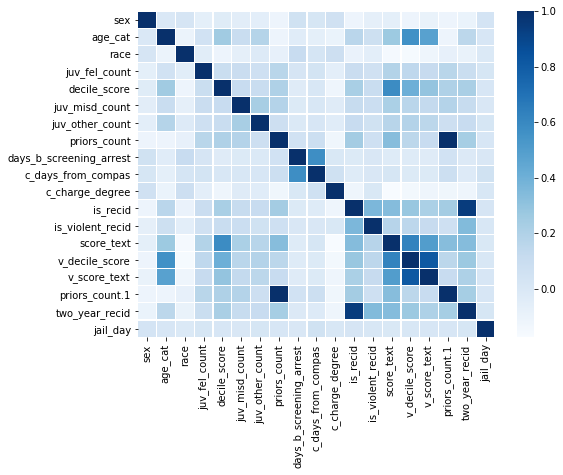

In [65]:
#correlation matrix to check further correlation if any
plt.figure(figsize=(8,6))
corr=data.apply(lambda x: pd.factorize(x)[0]).corr()
ax=sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, linewidth=0.2, cmap='Blues')

In [66]:
data['is_recid'].value_counts()

0    3182
1    2990
Name: is_recid, dtype: int64

In [67]:
data['two_year_recid'].value_counts()

0    3363
1    2809
Name: two_year_recid, dtype: int64

In [68]:
#we can also remove this column as score_text represents the degree of charge
data['c_charge_degree'].unique()

array(['F', 'M'], dtype=object)

In [69]:
data.columns

Index(['sex', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_days_from_compas', 'c_charge_degree',
       'is_recid', 'is_violent_recid', 'score_text', 'v_decile_score',
       'v_score_text', 'priors_count.1', 'two_year_recid', 'jail_day'],
      dtype='object')

In [70]:
list4=['jail_day','v_decile_score','priors_count.1','c_days_from_compas','is_violent_recid','v_score_text']
data=data.drop(columns=list4)

In [71]:
data.shape

(6172, 13)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 13 columns):
sex                        6172 non-null object
age_cat                    6172 non-null object
race                       6172 non-null object
juv_fel_count              6172 non-null int64
decile_score               6172 non-null int64
juv_misd_count             6172 non-null int64
juv_other_count            6172 non-null int64
priors_count               6172 non-null int64
days_b_screening_arrest    6172 non-null float64
c_charge_degree            6172 non-null object
is_recid                   6172 non-null int64
score_text                 6172 non-null object
two_year_recid             6172 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 675.1+ KB


In [73]:
data['days_b_screening_arrest'].unique()

array([ -1.,   0., -20.,  22.,  -2., -24., -13., -15., -10., -30.,  -4.,
       -16., -26.,  -7.,  29.,  -3.,  23., -11., -22., -21., -12.,  -8.,
        -5., -23., -14.,  -9.,  -6., -27., -19., -18.,  26., -29.,  28.,
         7., -17., -28.,   9., -25.,  13.,  20.,  17.,  30.,   6.,   2.,
        16.,   8.,   1.,  18.,  15.,  21.,  27.,  11.,   3.,  14.,   5.,
        24.])

In [74]:
pd.crosstab(data.sex, data.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


Text(0, 0.5, 'Count')

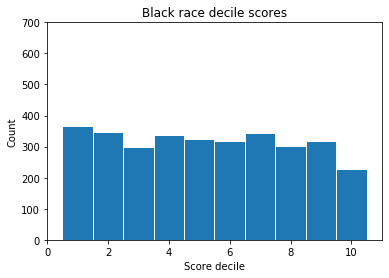

In [75]:
# some initial plottings from data
non_white_df = data[data['race'] == 'African-American']
non_white_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('Black race decile scores')
plt.xlabel('Score decile')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

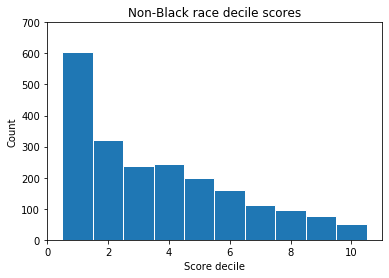

In [76]:
white_df = data[data['race'] == 'Caucasian']
white_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('Non-Black race decile scores')
plt.xlabel('Score decile')
plt.ylabel('Count')

In [77]:
pd.crosstab(data.decile_score,data.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


<b>  There is a clear downward trend in the decile scores as those scores increase for white defendants.

In [78]:
cat_list = ['sex','age_cat','race','c_charge_degree','score_text']
data_cat = pd.get_dummies(data[cat_list])

In [79]:
data_cat

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,score_text_High,score_text_Low,score_text_Medium
0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0
1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0
2,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0
5,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0
6,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1
7210,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0
7211,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0
7212,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0


In [80]:
data_num=data.drop(columns=cat_list)

In [81]:
data_num

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_recid,two_year_recid
0,0,1,0,0,0,-1.0,0,0
1,0,3,0,0,0,-1.0,1,1
2,0,4,0,1,4,-1.0,1,1
5,0,1,0,0,0,0.0,0,0
6,0,6,0,0,14,-1.0,1,1
...,...,...,...,...,...,...,...,...
7209,0,7,0,0,0,-1.0,0,0
7210,0,3,0,0,0,-1.0,0,0
7211,0,1,0,0,0,-1.0,0,0
7212,0,2,0,0,3,-1.0,0,0


In [82]:
data_fin=pd.concat([data_cat,data_num], axis=1)

In [83]:
data_fin

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,...,score_text_Low,score_text_Medium,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_recid,two_year_recid
0,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,-1.0,0,0
1,0,1,1,0,0,1,0,0,0,0,...,1,0,0,3,0,0,0,-1.0,1,1
2,0,1,0,0,1,1,0,0,0,0,...,1,0,0,4,0,1,4,-1.0,1,1
5,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0.0,0,0
6,0,1,1,0,0,0,0,1,0,0,...,0,1,0,6,0,0,14,-1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,1,0,0,1,1,0,0,0,0,...,0,1,0,7,0,0,0,-1.0,0,0
7210,0,1,0,0,1,1,0,0,0,0,...,1,0,0,3,0,0,0,-1.0,0,0
7211,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,-1.0,0,0
7212,1,0,1,0,0,1,0,0,0,0,...,1,0,0,2,0,0,3,-1.0,0,0


In [84]:
#Using Random forest feature importance
X=data_fin.drop(columns=['two_year_recid'])
y=data_fin['two_year_recid']
model = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
model.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [85]:
df_imp = pd.DataFrame(model.feature_importances_)
df_columns = pd.DataFrame(X.columns)
features = pd.concat([df_columns,df_imp],axis=1)
features.columns = ['features','imp']

#sorting the rows according to the feature importances in the descending order.
data_fea = features.sort_values(by = 'imp',ascending=False)
data_fea.reset_index(drop = True, inplace=True)

data_fea

,features,imp
0,is_recid,0.764837
1,priors_count,0.061966
2,decile_score,0.048994
3,days_b_screening_arrest,0.023601
4,score_text_Low,0.021904
5,score_text_High,0.010314
6,juv_other_count,0.008725
7,race_African-American,0.006018
8,age_cat_Less than 25,0.005864
9,juv_misd_count,0.005443


<b> From the feature importance table we can see that the feature importance of Caucasian race is much lower than the 
African-american race. This shows us the importance of features when the fit is performed.

In [86]:
df_score = pd.get_dummies(data['score_text'] != 'Low',prefix='score_factor',drop_first=True)
X1=data_fin.drop(columns=['score_text_Low','score_text_High','score_text_Medium'])
y1 = df_score.values.ravel()

In [87]:
#to check how the Compas scores (score_text) are related to the race

lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')
lr_model.fit(X1,y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
df_coef = (pd.DataFrame(lr_model.coef_)).T
df_columns1 = pd.DataFrame(X1.columns)
features = pd.concat([df_columns1,df_coef],axis=1)
features.columns = ['features','coeff']
features


,features,coeff
0,sex_Female,0.062703
1,sex_Male,-0.062764
2,age_cat_25 - 45,0.030244
3,age_cat_Greater than 45,-0.015404
4,age_cat_Less than 25,-0.014901
5,race_African-American,0.069547
6,race_Asian,0.016428
7,race_Caucasian,0.002347
8,race_Hispanic,0.013005
9,race_Native American,-0.000022


In [89]:
cols=X1.columns

In [90]:
print('%.3f' % lr_model.intercept_, '(Intercept)') 
for i,j in zip(cols, lr_model.coef_[0]): print('%.3f' % j, i)


-38.577 (Intercept)
0.063 sex_Female
-0.063 sex_Male
0.030 age_cat_25 - 45
-0.015 age_cat_Greater than 45
-0.015 age_cat_Less than 25
0.070 race_African-American
0.016 race_Asian
0.002 race_Caucasian
0.013 race_Hispanic
-0.000 race_Native American
-0.101 race_Other
0.025 c_charge_degree_F
-0.025 c_charge_degree_M
-0.008 juv_fel_count
8.537 decile_score
0.038 juv_misd_count
0.076 juv_other_count
0.017 priors_count
0.004 days_b_screening_arrest
0.017 is_recid
0.045 two_year_recid


In [91]:
prob = np.exp(-38.577) / (1 + np.exp(-38.577))
nonwhite_odds = np.exp(0.070) / (1 - prob + (prob * np.exp(0.070)))
print('Non-White race: %.4f' % nonwhite_odds)


Non-White race: 1.0725


In [92]:
white_odds =np.exp(0.003) / (1 - prob + (prob * np.exp(0.003)))
print('White defendants: %.4f' % white_odds)

White defendants: 1.0030


<b> so we see that to get the Higher score_text the odds are more in favour of African-American race and less in Caucasian race

In [93]:
#prob is the probability of the event happening

In [94]:
fair_test = data.copy()

In [95]:
fair_test

,sex,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,score_text,two_year_recid
0,Male,Greater than 45,Other,0,1,0,0,0,-1.0,F,0,Low,0
1,Male,25 - 45,African-American,0,3,0,0,0,-1.0,F,1,Low,1
2,Male,Less than 25,African-American,0,4,0,1,4,-1.0,F,1,Low,1
5,Male,25 - 45,Other,0,1,0,0,0,0.0,M,0,Low,0
6,Male,25 - 45,Caucasian,0,6,0,0,14,-1.0,F,1,Medium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,Male,Less than 25,African-American,0,7,0,0,0,-1.0,F,0,Medium,0
7210,Male,Less than 25,African-American,0,3,0,0,0,-1.0,F,0,Low,0
7211,Male,Greater than 45,Other,0,1,0,0,0,-1.0,F,0,Low,0
7212,Female,25 - 45,African-American,0,2,0,0,3,-1.0,M,0,Low,0


In [96]:
fair_test['race']=fair_test['race'].apply(lambda x:1 if x=='African-American' else 0)

In [97]:
fair_test['sex'] = fair_test['sex'].apply(lambda x:1 if x=='Female' else 0)

In [98]:
fair_test

,sex,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,score_text,two_year_recid
0,0,Greater than 45,0,0,1,0,0,0,-1.0,F,0,Low,0
1,0,25 - 45,1,0,3,0,0,0,-1.0,F,1,Low,1
2,0,Less than 25,1,0,4,0,1,4,-1.0,F,1,Low,1
5,0,25 - 45,0,0,1,0,0,0,0.0,M,0,Low,0
6,0,25 - 45,0,0,6,0,0,14,-1.0,F,1,Medium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,Less than 25,1,0,7,0,0,0,-1.0,F,0,Medium,0
7210,0,Less than 25,1,0,3,0,0,0,-1.0,F,0,Low,0
7211,0,Greater than 45,0,0,1,0,0,0,-1.0,F,0,Low,0
7212,1,25 - 45,1,0,2,0,0,3,-1.0,M,0,Low,0


In [99]:
fair_test1=pd.get_dummies(fair_test)

In [100]:
fair_test1

,sex,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_recid,two_year_recid,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,score_text_High,score_text_Low,score_text_Medium
0,0,0,0,1,0,0,0,-1.0,0,0,0,1,0,1,0,0,1,0
1,0,1,0,3,0,0,0,-1.0,1,1,1,0,0,1,0,0,1,0
2,0,1,0,4,0,1,4,-1.0,1,1,0,0,1,1,0,0,1,0
5,0,0,0,1,0,0,0,0.0,0,0,1,0,0,0,1,0,1,0
6,0,0,0,6,0,0,14,-1.0,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,1,0,7,0,0,0,-1.0,0,0,0,0,1,1,0,0,0,1
7210,0,1,0,3,0,0,0,-1.0,0,0,0,0,1,1,0,0,1,0
7211,0,0,0,1,0,0,0,-1.0,0,0,0,1,0,1,0,0,1,0
7212,1,1,0,2,0,0,3,-1.0,0,0,1,0,0,0,1,0,1,0


In [101]:
# Making our data into a Binary label dataset
aif_fair = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=fair_test1,
                                                      label_names=["two_year_recid"],
                                                     protected_attribute_names=["sex","race"],
                                              privileged_protected_attributes = [0,0])


In [102]:
#Disparate impact measurement for Sex
#Taking the unprieveleged group as female

metric_aif= BinaryLabelDatasetMetric(aif_fair,
                                      unprivileged_groups=[{"sex":1}],
                                      privileged_groups=[{"sex":0}]) 
explainer_aif = MetricTextExplainer(metric_aif)

print(explainer_aif.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.2459083658494687


In [103]:
#Disparate impact measurement for Sex
#Taking the unprieveleged group as male

fair_test2 = data.copy()
fair_test2['race']=fair_test2['race'].apply(lambda x:1 if x=='African-American' else 0)
fair_test2['sex'] = fair_test2['sex'].apply(lambda x:1 if x=='Male' else 0)

fair_test3=pd.get_dummies(fair_test2)

aif_fair = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=fair_test3,
                                                      label_names=["two_year_recid"],
                                                     protected_attribute_names=["sex","race"],
                                              privileged_protected_attributes = [0,0])


metric_aif= BinaryLabelDatasetMetric(aif_fair,
                                      unprivileged_groups=[{"sex":1}],
                                      privileged_groups=[{"sex":0}]) 
explainer_aif = MetricTextExplainer(metric_aif)

print(explainer_aif.disparate_impact())


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8026272456387218


<b> so we see that there is no Disparate Impact for feature Sex. value between 0.8-1.2 indicates fairness among the groups

In [104]:
#Disparate impact measurement for Race
#Taking the unprieveleged group as African-American



metric_aif= BinaryLabelDatasetMetric(aif_fair,
                                      unprivileged_groups=[{"race":1}],
                                      privileged_groups=[{"race":0}]) 
explainer_aif = MetricTextExplainer(metric_aif)

print(explainer_aif.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7729154299195565


In [105]:
#Disparate impact measurement for Race
#Taking the unprieveleged group as Caucassian

fair_test4 = data.copy()
fair_test4['race']=fair_test4['race'].apply(lambda x:1 if x!='African-American' else 0)
fair_test4['sex'] = fair_test4['sex'].apply(lambda x:1 if x=='Male' else 0)

fair_test5=pd.get_dummies(fair_test4)

aif_fair = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=fair_test5,
                                                      label_names=["two_year_recid"],
                                                     protected_attribute_names=["sex","race"],
                                              privileged_protected_attributes = [0,0])


metric_aif= BinaryLabelDatasetMetric(aif_fair,
                                      unprivileged_groups=[{"sex":1}],
                                      privileged_groups=[{"sex":0}]) 
explainer_aif = MetricTextExplainer(metric_aif)

print(explainer_aif.disparate_impact())


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8026272456387218


<b> so we see that the disparate impact for American-African race and Non American-african race value is above 0.8 which indicates the fairness in treatment in the individuals among the group race

#Removing the biasness using IBM 360 AIF

In [106]:
#Running a random forest model without implementing IBM360 fair AI binarylabeldataset
#data_fin is our one hot encoded data
data_fin

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,...,score_text_Low,score_text_Medium,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_recid,two_year_recid
0,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,-1.0,0,0
1,0,1,1,0,0,1,0,0,0,0,...,1,0,0,3,0,0,0,-1.0,1,1
2,0,1,0,0,1,1,0,0,0,0,...,1,0,0,4,0,1,4,-1.0,1,1
5,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0.0,0,0
6,0,1,1,0,0,0,0,1,0,0,...,0,1,0,6,0,0,14,-1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,1,0,0,1,1,0,0,0,0,...,0,1,0,7,0,0,0,-1.0,0,0
7210,0,1,0,0,1,1,0,0,0,0,...,1,0,0,3,0,0,0,-1.0,0,0
7211,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,-1.0,0,0
7212,1,0,1,0,0,1,0,0,0,0,...,1,0,0,2,0,0,3,-1.0,0,0


In [107]:
#Scaling the data
scaler=MinMaxScaler()
scaled_list = pd.DataFrame(data=scaler.fit_transform(data_fin), columns= list(data_fin))

In [108]:
X=scaled_list.drop(columns=['two_year_recid','is_recid'])
y=scaled_list['two_year_recid']

In [109]:
#Splitting the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [111]:
y_pred=rf_clf.predict_proba(X_test)
forest_score=roc_auc_score(y_true=y_test,y_score=y_pred[:,1])
print("AUC Score:", forest_score)

AUC Score: 0.6776118254928174


In [112]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred[:,1].round()))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67       683
         1.0       0.60      0.58      0.59       552

    accuracy                           0.64      1235
   macro avg       0.63      0.63      0.63      1235
weighted avg       0.64      0.64      0.64      1235



In [113]:
from sklearn.metrics import confusion_matrix
confusion_matrix_forest = confusion_matrix(y_test, y_pred[:,1].round())
print("Confusion matrix for Random Forest:\n%s" % confusion_matrix_forest)

Confusion matrix for Random Forest:
[[464 219]
 [230 322]]


In [114]:
data

,sex,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,score_text,two_year_recid
0,Male,Greater than 45,Other,0,1,0,0,0,-1.0,F,0,Low,0
1,Male,25 - 45,African-American,0,3,0,0,0,-1.0,F,1,Low,1
2,Male,Less than 25,African-American,0,4,0,1,4,-1.0,F,1,Low,1
5,Male,25 - 45,Other,0,1,0,0,0,0.0,M,0,Low,0
6,Male,25 - 45,Caucasian,0,6,0,0,14,-1.0,F,1,Medium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,Male,Less than 25,African-American,0,7,0,0,0,-1.0,F,0,Medium,0
7210,Male,Less than 25,African-American,0,3,0,0,0,-1.0,F,0,Low,0
7211,Male,Greater than 45,Other,0,1,0,0,0,-1.0,F,0,Low,0
7212,Female,25 - 45,African-American,0,2,0,0,3,-1.0,M,0,Low,0


In [115]:
# df1 = data.copy()
# df1 = df1.drop(columns='is_recid')

In [116]:
# #df1.two_year_recid = df1.two_year_recid.replace({0:1, 1:0})
# df1['race']=df1['race'].apply(lambda x: 1 if x=='Caucasian' else 0)
# df1=pd.get_dummies(df1)
# df1=df1.astype(float)

In [117]:
# df1

In [118]:
# metadata = {'label_maps': [{0.0: 'favourable', 1.0: 'unfavourable'}], 
#             'protected_attribute_maps': [{0.0: 'Not Caucasian', 1.0: 'Caucasian'}]}
# unprivileged_groups=[{'race': [0.0]}]
# privileged_groups=[{'race': [1.0]}]
# protected_attribute_names = ['race']
# label_names = ['two_year_recid']
# dataset = BinaryLabelDataset(df = df1, label_names=label_names, 
#                             protected_attribute_names = protected_attribute_names, 
#                             instance_weights_name=None, unprivileged_protected_attributes=[], 
#                             privileged_protected_attributes=[], metadata=metadata)
# metric_orig = BinaryLabelDatasetMetric(dataset,
#                                        unprivileged_groups=unprivileged_groups,
#                                        privileged_groups=privileged_groups)
# disparate_impact_orig = MetricTextExplainer(metric_orig).disparate_impact()
# print(disparate_impact_orig)

In [119]:
#using IBM AIF360 tool
privileged_groups=[{"race":1}]
unprivileged_groups=[{"race":0}]
df1 = data.copy()
df1 = df1.drop(columns='is_recid')

df1['race']=df1['race'].apply(lambda x: 1 if x=='Caucasian' else 0)
df1=pd.get_dummies(df1)
df1=df1.astype(float)
dataset = BinaryLabelDataset(favorable_label = 0.0, 
                             unfavorable_label = 1.0, df=df1,
                             label_names=["two_year_recid"],
                             protected_attribute_names=["race"],
                             privileged_protected_attributes = [1.0])

# metric_orig = BinaryLabelDatasetMetric(dataset,
#                                        unprivileged_groups=[{"race":0}],
#                                        privileged_groups=[{"race":1}])
# disparate_impact_orig = MetricTextExplainer(metric_orig).disparate_impact()
# print(disparate_impact_orig)

In [120]:
dataset

               instance weights            features                \
                                protected attribute                 
                                               race juv_fel_count   
instance names                                                      
0                           1.0                 0.0           0.0   
1                           1.0                 0.0           0.0   
2                           1.0                 0.0           0.0   
5                           1.0                 0.0           0.0   
6                           1.0                 1.0           0.0   
...                         ...                 ...           ...   
7209                        1.0                 0.0           0.0   
7210                        1.0                 0.0           0.0   
7211                        1.0                 0.0           0.0   
7212                        1.0                 0.0           0.0   
7213                        1.0   

In [121]:
# dataset = BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=df1,
#                                                       label_names=["two_year_recid"],
#                                                      protected_attribute_names=["race"],
#                                               privileged_protected_attributes = [1.0])

# metric_aif= BinaryLabelDatasetMetric(dataset,
#                                       unprivileged_groups=[{"race":0}],
#                                       privileged_groups=[{"race":1}])

# explainer_aif = MetricTextExplainer(metric_aif).disparate_impact()
# explainer_aif


In [122]:
type(dataset)

aif360.datasets.binary_label_dataset.BinaryLabelDataset

In [123]:
#Scaking the dataset
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)  
X_train = scale.transform(dataset_train.features)     
y_train = dataset_train.labels.ravel()
X_test = scale.transform(dataset_test.features)   
y_test = dataset_test.labels.ravel()


In [124]:
#Running Random Forest Model on the original data without implementing reweighing
model_rf = RandomForestClassifier(n_estimators=300,min_samples_split=10, max_depth=10,n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [125]:
y_pred_test = model_rf.predict(X_test)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Test accuracy: ", acc_test)
y_pred_train = model_rf.predict(X_train)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Train accuracy: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

bin_metric = BinaryLabelDatasetMetric(dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

disparate_impact_bin = bin_metric.disparate_impact()
print('Disparate impact: ', disparate_impact_bin)
mean_difference = bin_metric.mean_difference()
print('Mean difference: ', mean_difference)


classif_metric = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

#classif_disparate_impact = classif_metric.disparate_impact()
avg_odds = classif_metric.average_odds_difference()
print('Average odds difference:', avg_odds)
equal_opport = classif_metric.equal_opportunity_difference()
print('Equality of opportunity:', equal_opport)
false_discovery_rate = classif_metric.false_discovery_rate_difference()
print('False discovery rate difference:', false_discovery_rate)


Test accuracy:  0.677645788336933
Train accuracy:  0.7456018518518519
Disparate impact:  0.7523284710967044
Mean difference:  -0.18034334628880744
Average odds difference: -0.1483539799888143
Equality of opportunity: -0.11400901209608338
False discovery rate difference: 0.0461604207758054


In [126]:
#Confusion Matrix for the original data using Random Forest
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,762,233,995
1.0,364,493,857
All,1126,726,1852


In [127]:
confusion_rf = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix for Random Forest Model :\n%s" % confusion_rf)

Confusion matrix for Random Forest Model :
[[762 233]
 [364 493]]


In [128]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72       995
         1.0       0.68      0.58      0.62       857

    accuracy                           0.68      1852
   macro avg       0.68      0.67      0.67      1852
weighted avg       0.68      0.68      0.67      1852



In [129]:
# For XGBoost Model
model_gb =  XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_gb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [130]:
y_pred_test = model_gb.predict(X_test)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Test accuracy: ", acc_test)
y_pred_train = model_gb.predict(X_train)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Train accuracy: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

bin_metric = BinaryLabelDatasetMetric(dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

disparate_impact_bin = bin_metric.disparate_impact()
print('Disparate impact: ', disparate_impact_bin)
mean_difference = bin_metric.mean_difference()
print('Mean difference: ', mean_difference)


classif_metric = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

#classif_disparate_impact = classif_metric.disparate_impact()
avg_odds = classif_metric.average_odds_difference()
print('Average odds difference:', avg_odds)
equal_opport = classif_metric.equal_opportunity_difference()
print('Equality of opportunity:', equal_opport)
false_discovery_rate = classif_metric.false_discovery_rate_difference()
print('False discovery rate difference:', false_discovery_rate)


Test accuracy:  0.6727861771058316
Train accuracy:  0.732175925925926
Disparate impact:  0.7682886400471489
Mean difference:  -0.1649724892868195
Average odds difference: -0.13288978065040616
Equality of opportunity: -0.10467138402494602
False discovery rate difference: 0.053484848484848524


In [131]:
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix for XGBoost Model :\n%s" % confusion_matrix_xgb)

Confusion matrix for XGBoost Model :
[[752 243]
 [363 494]]


In [132]:
#confusion matrix for XGBoost model on original data
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,752,243,995
1.0,363,494,857
All,1115,737,1852


[[752 243]
 [363 494]]


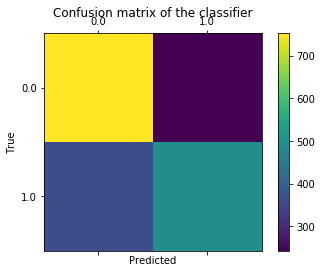

In [133]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

labels = ['0.0', '1.0'] 

cm = confusion_matrix(list(y_test), list(y_pred_test), labels=[0.0,1.0]) 

print(cm) 

fig = plt.figure() 

ax = fig.add_subplot(111) 

cax = ax.matshow(cm) 

plt.title('Confusion matrix of the classifier') 

fig.colorbar(cax) 

ax.set_xticklabels([''] + labels) 

ax.set_yticklabels([''] + labels) 

plt.xlabel('Predicted') 

plt.ylabel('True') 

plt.show()

In [134]:
#with transformed data

In [135]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_tf_train = RW.transform(dataset_train)

# metric_transf = BinaryLabelDatasetMetric(dataset_tf_train,
#                                          unprivileged_groups=unprivileged_groups,
#                                          privileged_groups=privileged_groups)

metric_orig = BinaryLabelDatasetMetric(dataset_tf_train,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = MetricTextExplainer(metric_orig).disparate_impact()
print(disparate_impact_orig)

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


In [136]:
scale_tf = StandardScaler().fit(dataset_tf_train.features) 
X_train_tf = scale.transform(dataset_tf_train.features)  
y_train = dataset_tf_train.labels.ravel()
X_test_tf = scale_tf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

In [137]:
# RandomForest model on the Transformed data after implementing Reweighing pre-processing algorithm
model_tf_rf = RandomForestClassifier(n_estimators=300, min_samples_split=10, max_depth=10,n_jobs=-1)
model_tf_rf.fit(X_train_tf, y_train,sample_weight=dataset_tf_train.instance_weights)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [138]:
y_pred_test = model_tf_rf.predict(X_test_tf)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Test accuracy: ", acc_test)
y_pred_train = model_tf_rf.predict(X_train_tf)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Train accuracy: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

bin_metric = BinaryLabelDatasetMetric(dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

disparate_impact_bin = bin_metric.disparate_impact()
print('Disparate impact: ', disparate_impact_bin)
mean_difference = bin_metric.mean_difference()
print('Mean difference: ', mean_difference)


classif_metric = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

#classif_disparate_impact = classif_metric.disparate_impact()
avg_odds = classif_metric.average_odds_difference()
print('Average odds difference:', avg_odds)
equal_opport = classif_metric.equal_opportunity_difference()
print('Equality of opportunity:', equal_opport)
false_discovery_rate = classif_metric.false_discovery_rate_difference()
print('False discovery rate difference:', false_discovery_rate)


Test accuracy:  0.6852051835853131
Train accuracy:  0.74375
Disparate impact:  0.8416882954970474
Mean difference:  -0.10989598904816611
Average odds difference: -0.07258422200274653
Equality of opportunity: -0.05759346194702397
False discovery rate difference: 0.07306932549650996


In [139]:
#confusion matrix for the RandomForest Model
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,781,214,995
1.0,369,488,857
All,1150,702,1852


In [140]:
confusion_matrix_rf_tf = confusion_matrix(y_test, y_pred_test)
print("Confusion matrix for Random Forest Model :\n%s" % confusion_matrix_rf_tf)

Confusion matrix for Random Forest Model :
[[781 214]
 [369 488]]


In [141]:
#Using XgBoost on the transformed data after implementing reweighing

In [142]:
model_gb_tf =  XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_gb_tf.fit(X_train_tf, y_train,sample_weight=dataset_tf_train.instance_weights)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [143]:
y_pred_test = model_gb_tf.predict(X_test_tf)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print("Test accuracy: ", acc_test)
y_pred_train = model_gb_tf.predict(X_train_tf)
acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print("Train accuracy: ", acc_train)

dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred_test

bin_metric = BinaryLabelDatasetMetric(dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

disparate_impact_bin = bin_metric.disparate_impact()
print('Disparate impact: ', disparate_impact_bin)
mean_difference = bin_metric.mean_difference()
print('Mean difference: ', mean_difference)


classif_metric = ClassificationMetric(dataset_test, dataset_pred, 
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

#classif_disparate_impact = classif_metric.disparate_impact()
avg_odds = classif_metric.average_odds_difference()
print('Average odds difference:', avg_odds)
equal_opport = classif_metric.equal_opportunity_difference()
print('Equality of opportunity:', equal_opport)
false_discovery_rate = classif_metric.false_discovery_rate_difference()
print('False discovery rate difference:', false_discovery_rate)

Test accuracy:  0.67170626349892
Train accuracy:  0.7400462962962963
Disparate impact:  0.9169248736771856
Mean difference:  -0.054845714465547424
Average odds difference: -0.021504756238542755
Equality of opportunity: 0.0028869547339204216
False discovery rate difference: 0.07824434994881485


[[771 224]
 [384 473]]


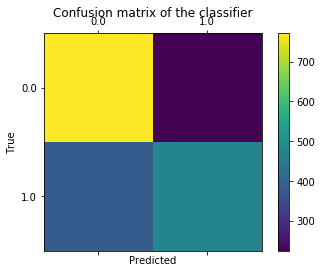

In [144]:
# confusion_matrix_xgb_tf = confusion_matrix(y_test, y_pred_test)
# print("Confusion matrix for XGBoost Model :\n%s" % confusion_matrix_xgb_tf)

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

labels = ['0.0', '1.0'] 

cm = confusion_matrix(list(y_test), list(y_pred_test), labels=[0.0,1.0]) 

print(cm) 

fig = plt.figure() 

ax = fig.add_subplot(111) 

cax = ax.matshow(cm) 

plt.title('Confusion matrix of the classifier') 

fig.colorbar(cax) 

ax.set_xticklabels([''] + labels) 

ax.set_yticklabels([''] + labels) 

plt.xlabel('Predicted') 

plt.ylabel('True') 

plt.show()

In [145]:
#confusion matrix for the XGBoost on transformed data
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,771,224,995
1.0,384,473,857
All,1155,697,1852


In [146]:
#shap explanation

In [147]:
import shap
shap.initjs()

<b> Before Transformation

In [148]:
shap_values_gb = shap.TreeExplainer(model_gb).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


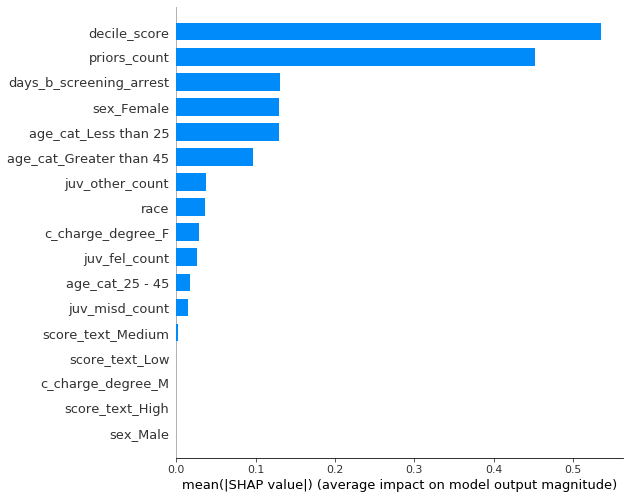

In [149]:
shap.summary_plot(shap_values_gb, X_train, plot_type="bar",feature_names=dataset_train.feature_names)

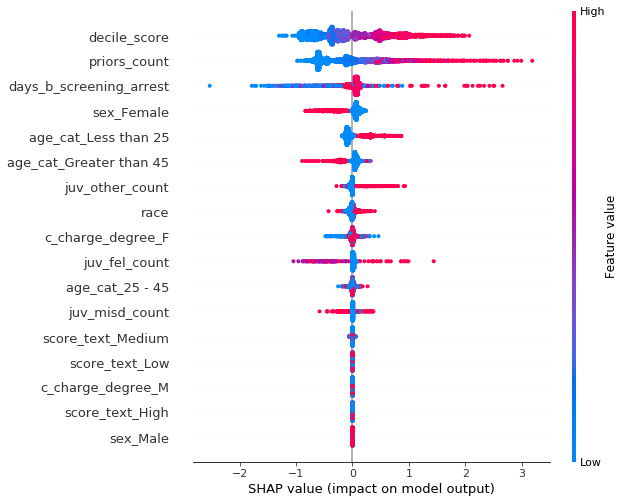

In [150]:
shap.summary_plot(shap_values_gb, X_train,feature_names=dataset_train.feature_names)

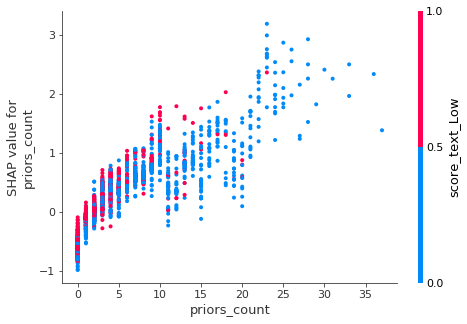

In [151]:
# shap.dependence_plot('race',shap_values_gb, X_train)
shap.dependence_plot('priors_count', shap_values_gb, dataset_train.features, 
                         dataset_train.feature_names)

In [152]:
explainer = shap.TreeExplainer(model_gb)
shap.force_plot(explainer.expected_value, shap_values_gb[0,:], X_train[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<b> After Transformation

In [153]:
shap_values_gb_tf = shap.TreeExplainer(model_gb_tf).shap_values(X_train_tf)

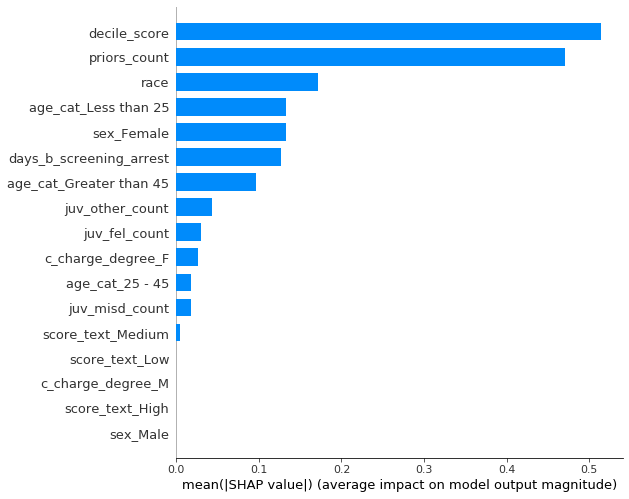

In [154]:
shap.summary_plot(shap_values_gb_tf, X_train_tf, plot_type="bar",feature_names=dataset_train.feature_names)

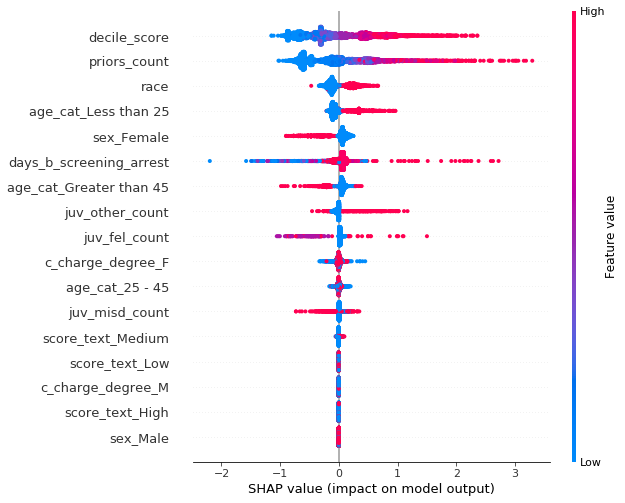

In [155]:
shap.summary_plot(shap_values_gb_tf, X_train_tf,feature_names=dataset_train.feature_names)

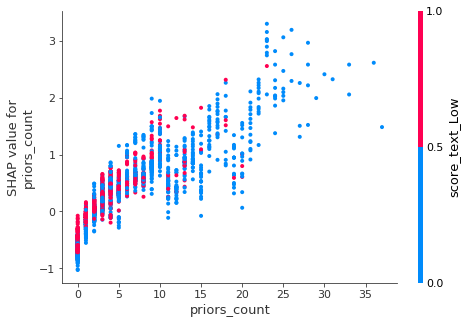

In [156]:
# shap.dependence_plot('race',shap_values_gb, X_train)
shap.dependence_plot('priors_count', shap_values_gb_tf, dataset_train.features, 
                         dataset_train.feature_names)

In [157]:
explainer_tf = shap.TreeExplainer(model_gb_tf)
shap.force_plot(explainer_tf.expected_value, shap_values_gb_tf[0,:], X_train_tf[0,:],feature_names=dataset_train.feature_names)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [158]:
# so reweighing pre processing algorithm does not changes or edits the feature values.
#inference from what-if tool.